# Compare protein abundance across U2OS and DUAL assays

In [1]:
import polars as pl
import plotnine as plotnine

In [2]:
prof_dir = "/dgx1nas1/storage/data/jess/repos/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/outputs/batch_profiles"

In [3]:
sc_abun_stats = pl.read_csv("../results/sc_abundance_changes.csv")
well_abun_stats = pl.read_csv("../results/well_abundance_changes.csv")

In [4]:
# Compare to dual data
dual_abun = (
    pl.read_csv("../data/abundance_ppi_his3_edgotyping.tsv", separator="\t")
    .filter(pl.col("node_type") == "allele")
    .with_columns(
        pl.concat_str(["symbol", "aa_change"], separator="_").alias("Variant")
    )
    .select(["Variant", "z_abundance_change"])
    .filter(pl.col("z_abundance_change").is_not_null())
    .with_columns(pl.col("z_abundance_change").cast(pl.Float64))
    .rename({"z_abundance_change": "dual_Z"})
)
abun_dual_sc = sc_abun_stats.join(dual_abun, on="Variant", how="left").filter(
    pl.col("dual_Z").is_not_null()
)
abun_dual_well = well_abun_stats.join(dual_abun, on="Variant", how="left").filter(
    pl.col("dual_Z").is_not_null()
)

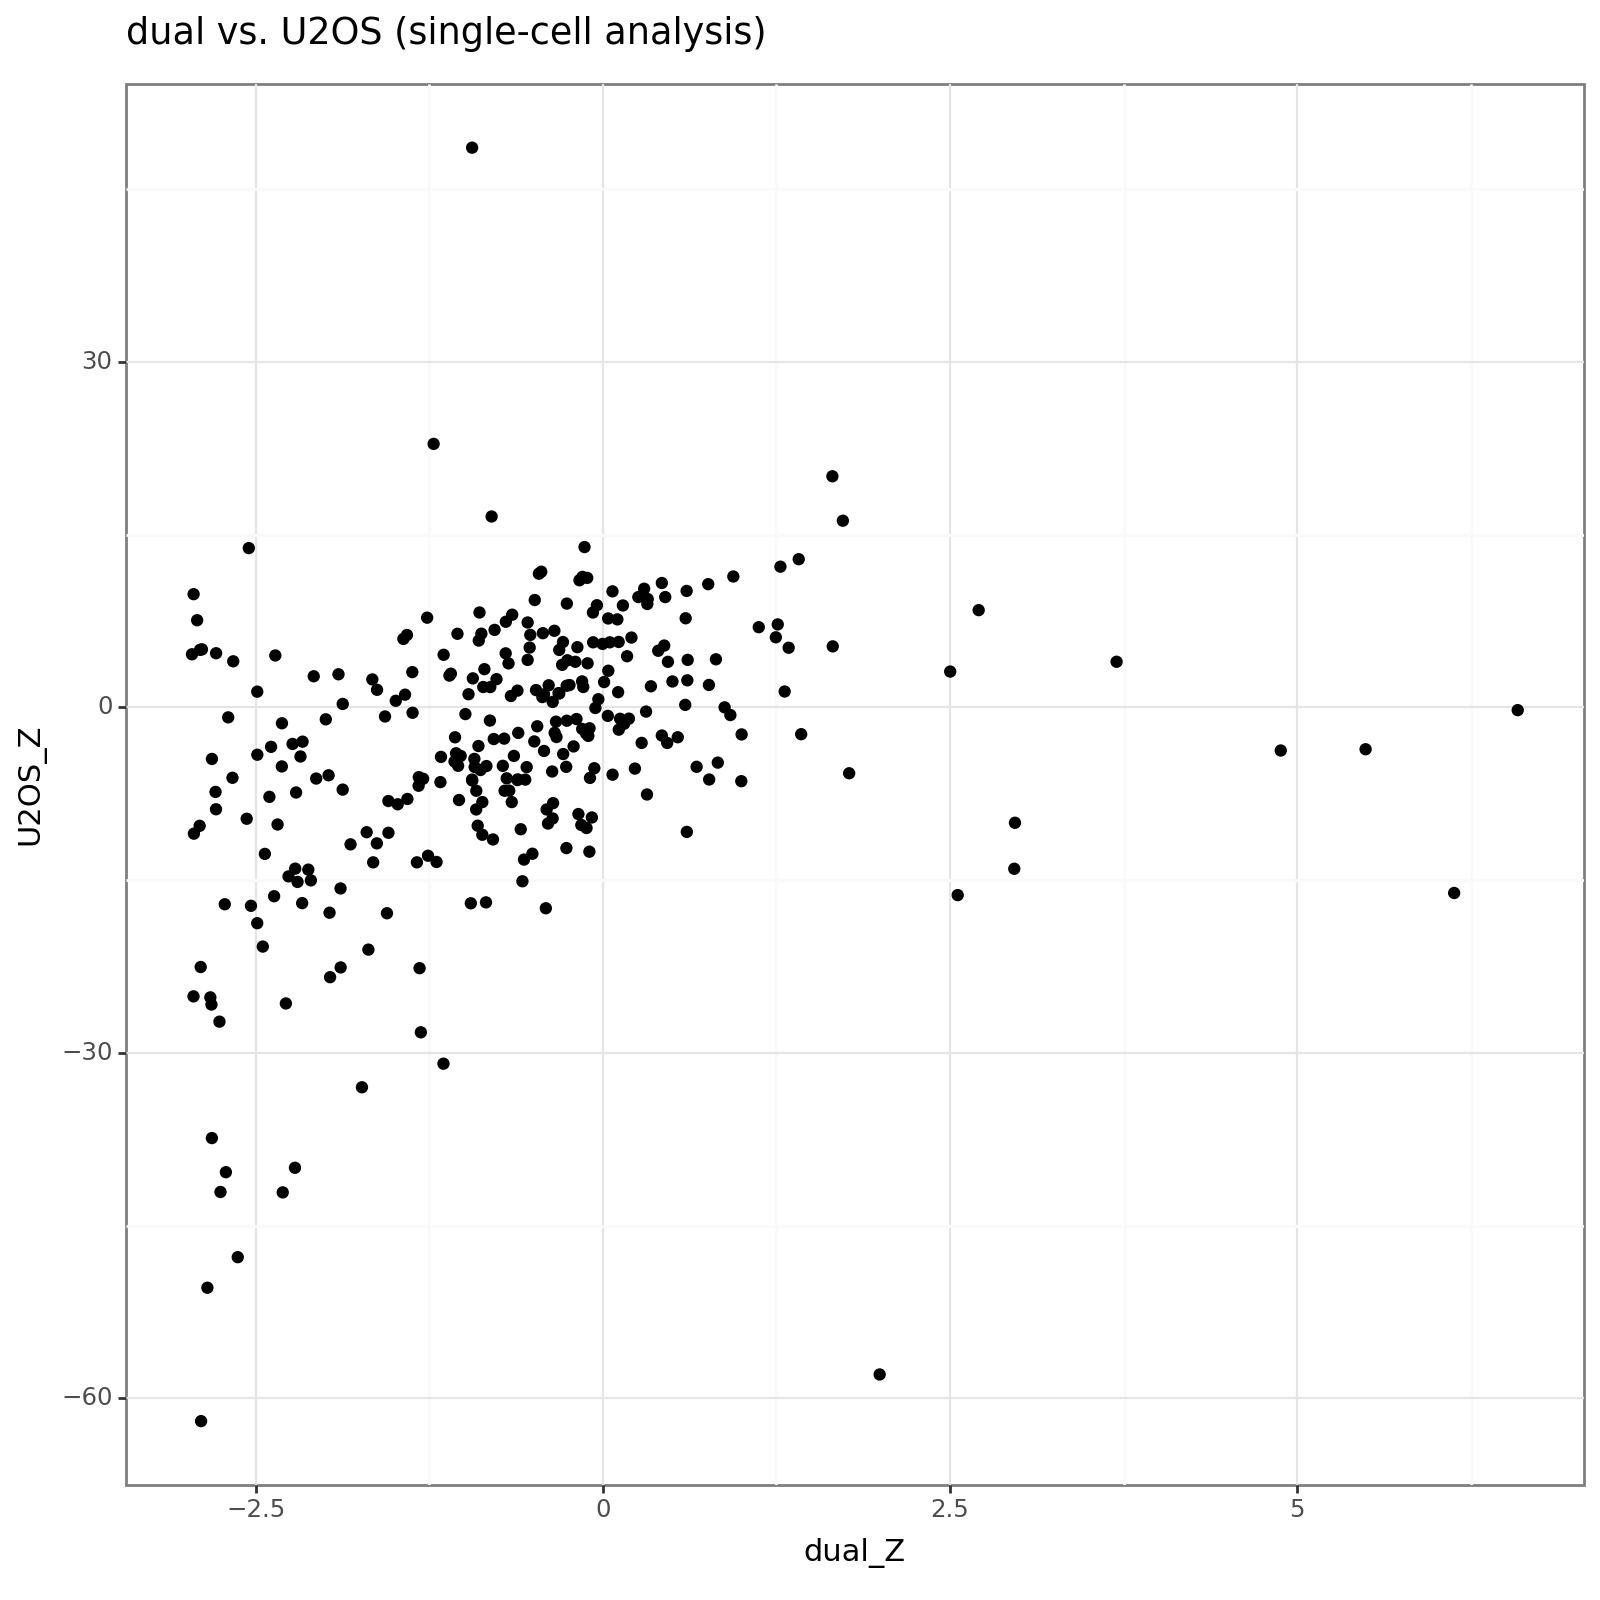

In [5]:
from plotnine import aes, geom_point, ggplot, theme_bw, labs

plotnine.options.figure_size = (8, 8)
plot1 = (
    ggplot(
        abun_dual_sc,
        aes(x="dual_Z", y="U2OS_Z"),
    )
    + geom_point()
    + theme_bw()
    + labs(title="dual vs. U2OS (single-cell analysis)")
)
print(plot1)

In [8]:
from scipy.stats import pearsonr

u2os_z = abun_dual_sc["U2OS_Z"].to_numpy()
dual_z = abun_dual_sc["dual_Z"].to_numpy()

corr_coeff, p_value = pearsonr(u2os_z, dual_z)

print("SC stats: ")
print(f"Pearson correlation coefficient: {corr_coeff}")
print(f"P-value: {p_value}")

SC stats: 
Pearson correlation coefficient: 0.32056490693417244
P-value: 1.1409530313557542e-08


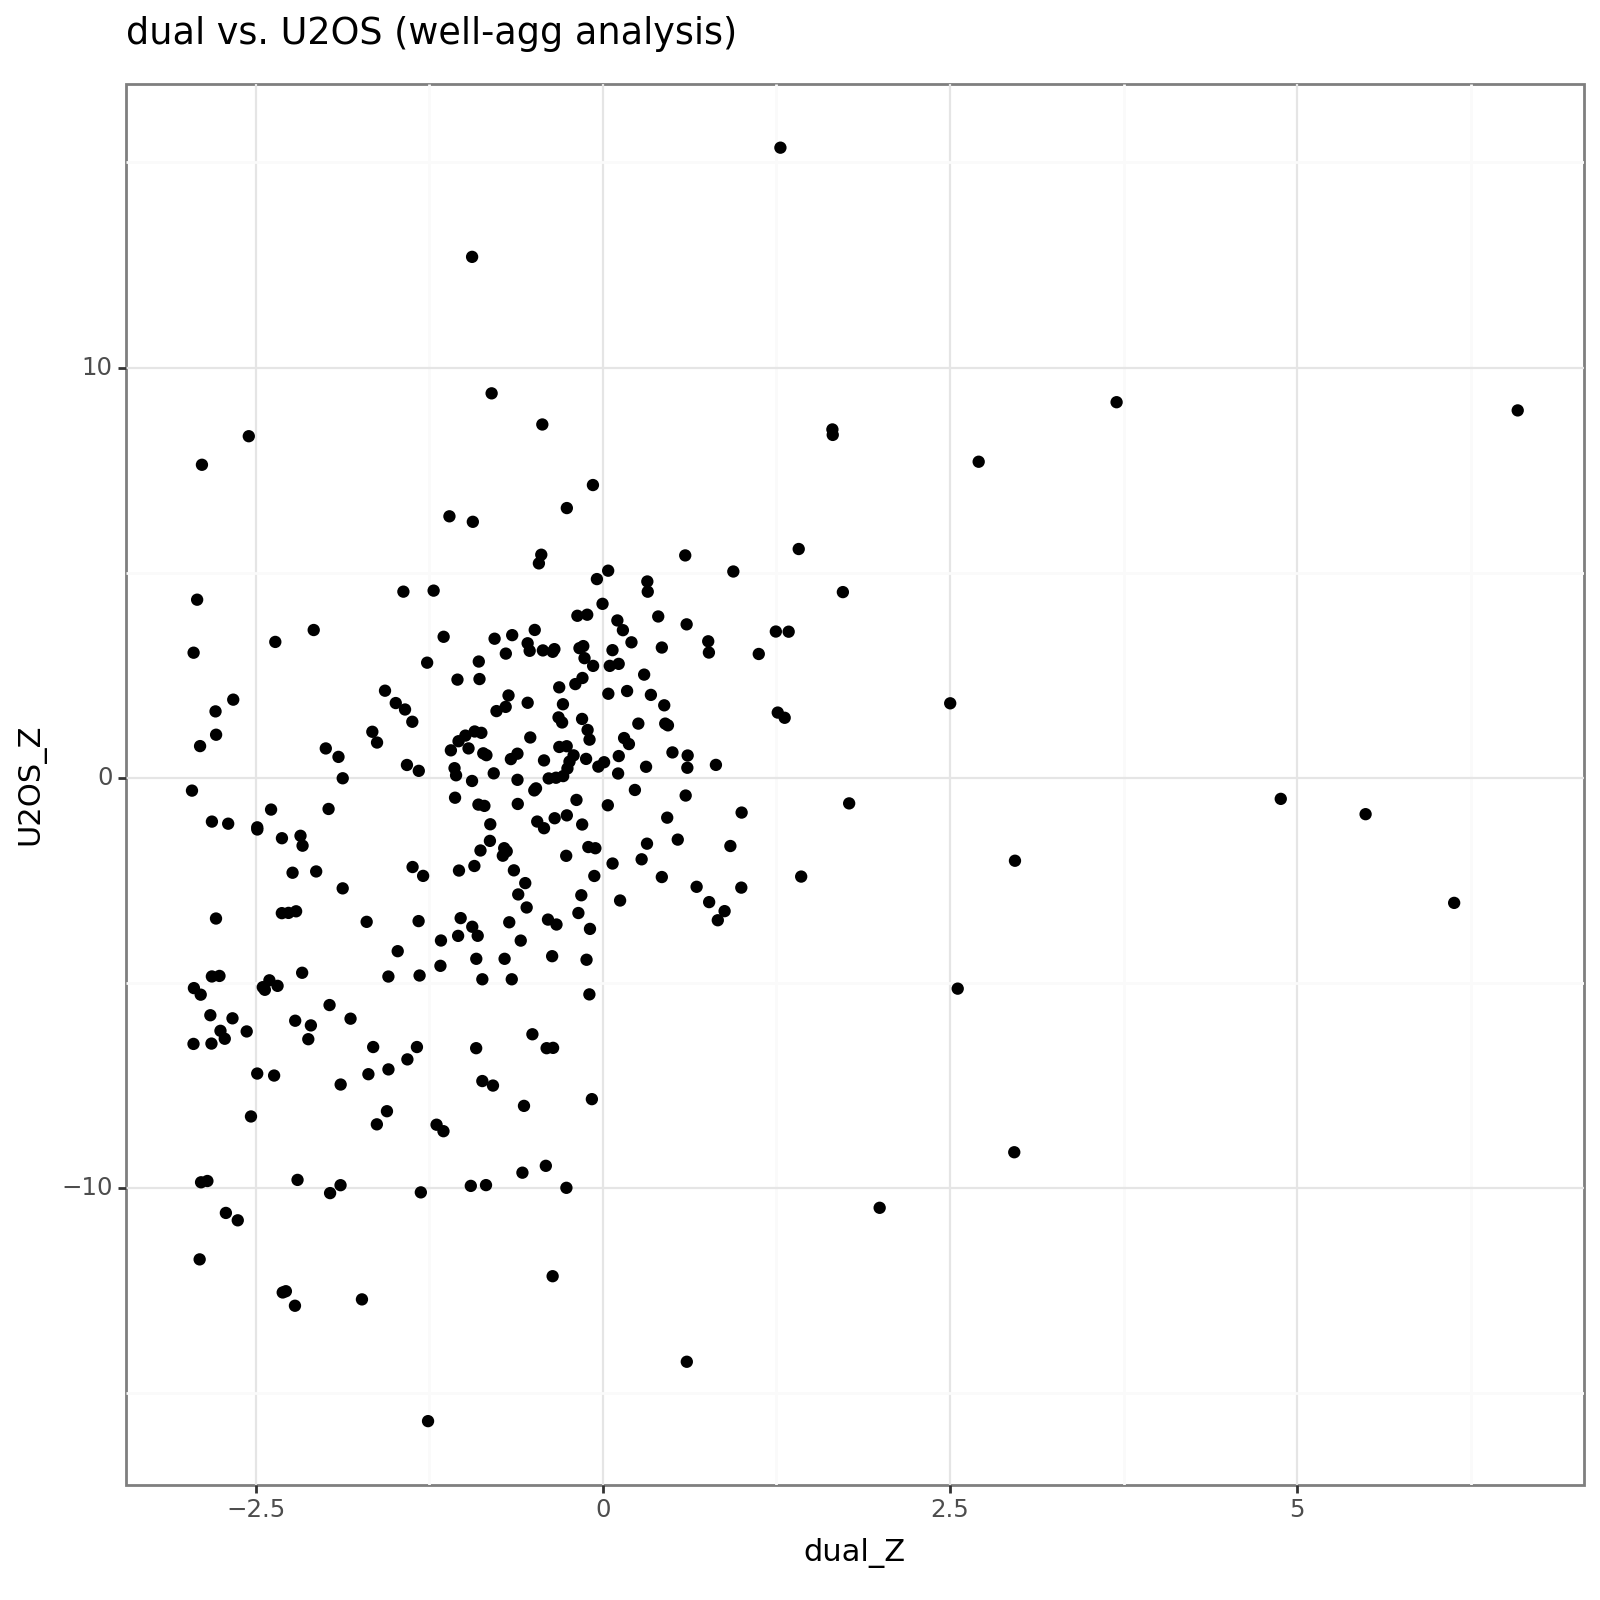

In [6]:
from plotnine import aes, geom_point, ggplot, theme_bw, labs

plotnine.options.figure_size = (8, 8)
plot1 = (
    ggplot(
        abun_dual_well,
        aes(x="dual_Z", y="U2OS_Z"),
    )
    + geom_point()
    + theme_bw()
    + labs(title="dual vs. U2OS (well-agg analysis)")
)
print(plot1)

In [7]:
from scipy.stats import pearsonr

u2os_z = abun_dual_well["U2OS_Z"].to_numpy()
dual_z = abun_dual_well["dual_Z"].to_numpy()

corr_coeff, p_value = pearsonr(u2os_z, dual_z)

print("Well-agg stats: ")
print(f"Pearson correlation coefficient: {corr_coeff}")
print(f"P-value: {p_value}")

Well-agg stats: 
Pearson correlation coefficient: 0.34207201195222053
P-value: 9.639750102498583e-10


/dgx1nas1/storage/data/jess/miniforge3/envs/varchamp/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 17'. Pick better value with 'binwidth'.


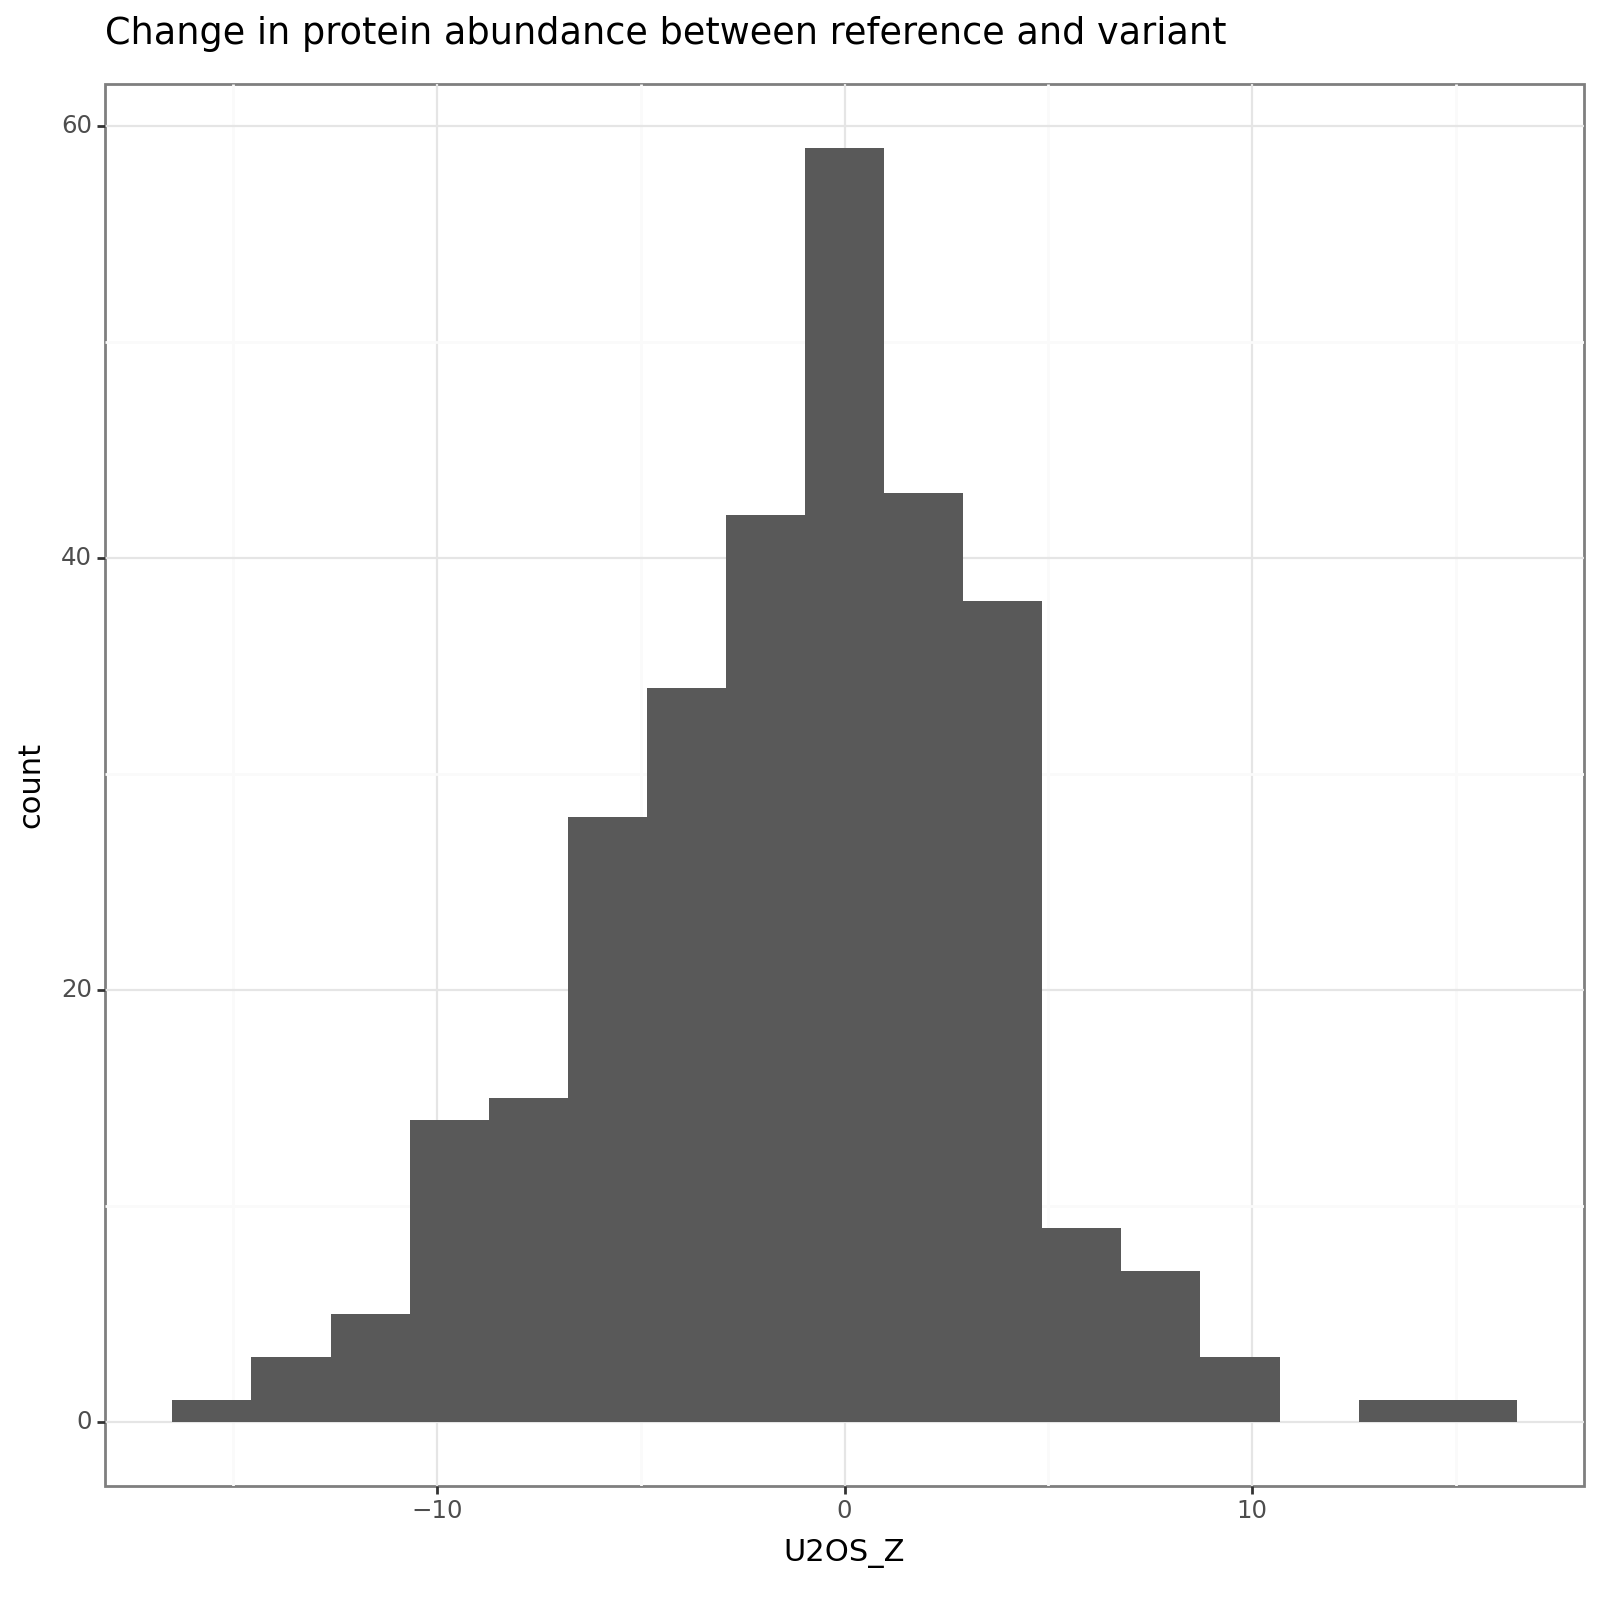

In [9]:
from plotnine import aes, geom_histogram, ggplot, theme_bw, labs

plotnine.options.figure_size = (8, 8)
plot1 = (
    ggplot(
        abun_dual_well,
        aes(x="U2OS_Z"),
    )
    + geom_histogram()
    + theme_bw()
    + labs(title="Change in protein abundance between reference and variant")
)
print(plot1)

## Analyze wrt clinvar annotations

In [10]:
well_abun_stats = pl.read_csv("../results/well_abundance_changes.csv")

clinvar = pl.read_csv("../data/allele_collection_clinical_significance.csv")
clinvar = clinvar.with_columns(
    pl.concat_str(["symbol", "aa_change"], separator="_").alias("Variant")
).select(["Variant", "clinvar_cs"]).with_columns(
    pl.when(pl.col("clinvar_cs").is_not_null()).then("clinvar_cs").otherwise(pl.lit("not provided")).alias("clinvar_cs")
)

well_abun_stats = well_abun_stats.join(clinvar, on="Variant")

/dgx1nas1/storage/data/jess/miniforge3/envs/varchamp/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 30'. Pick better value with 'binwidth'.


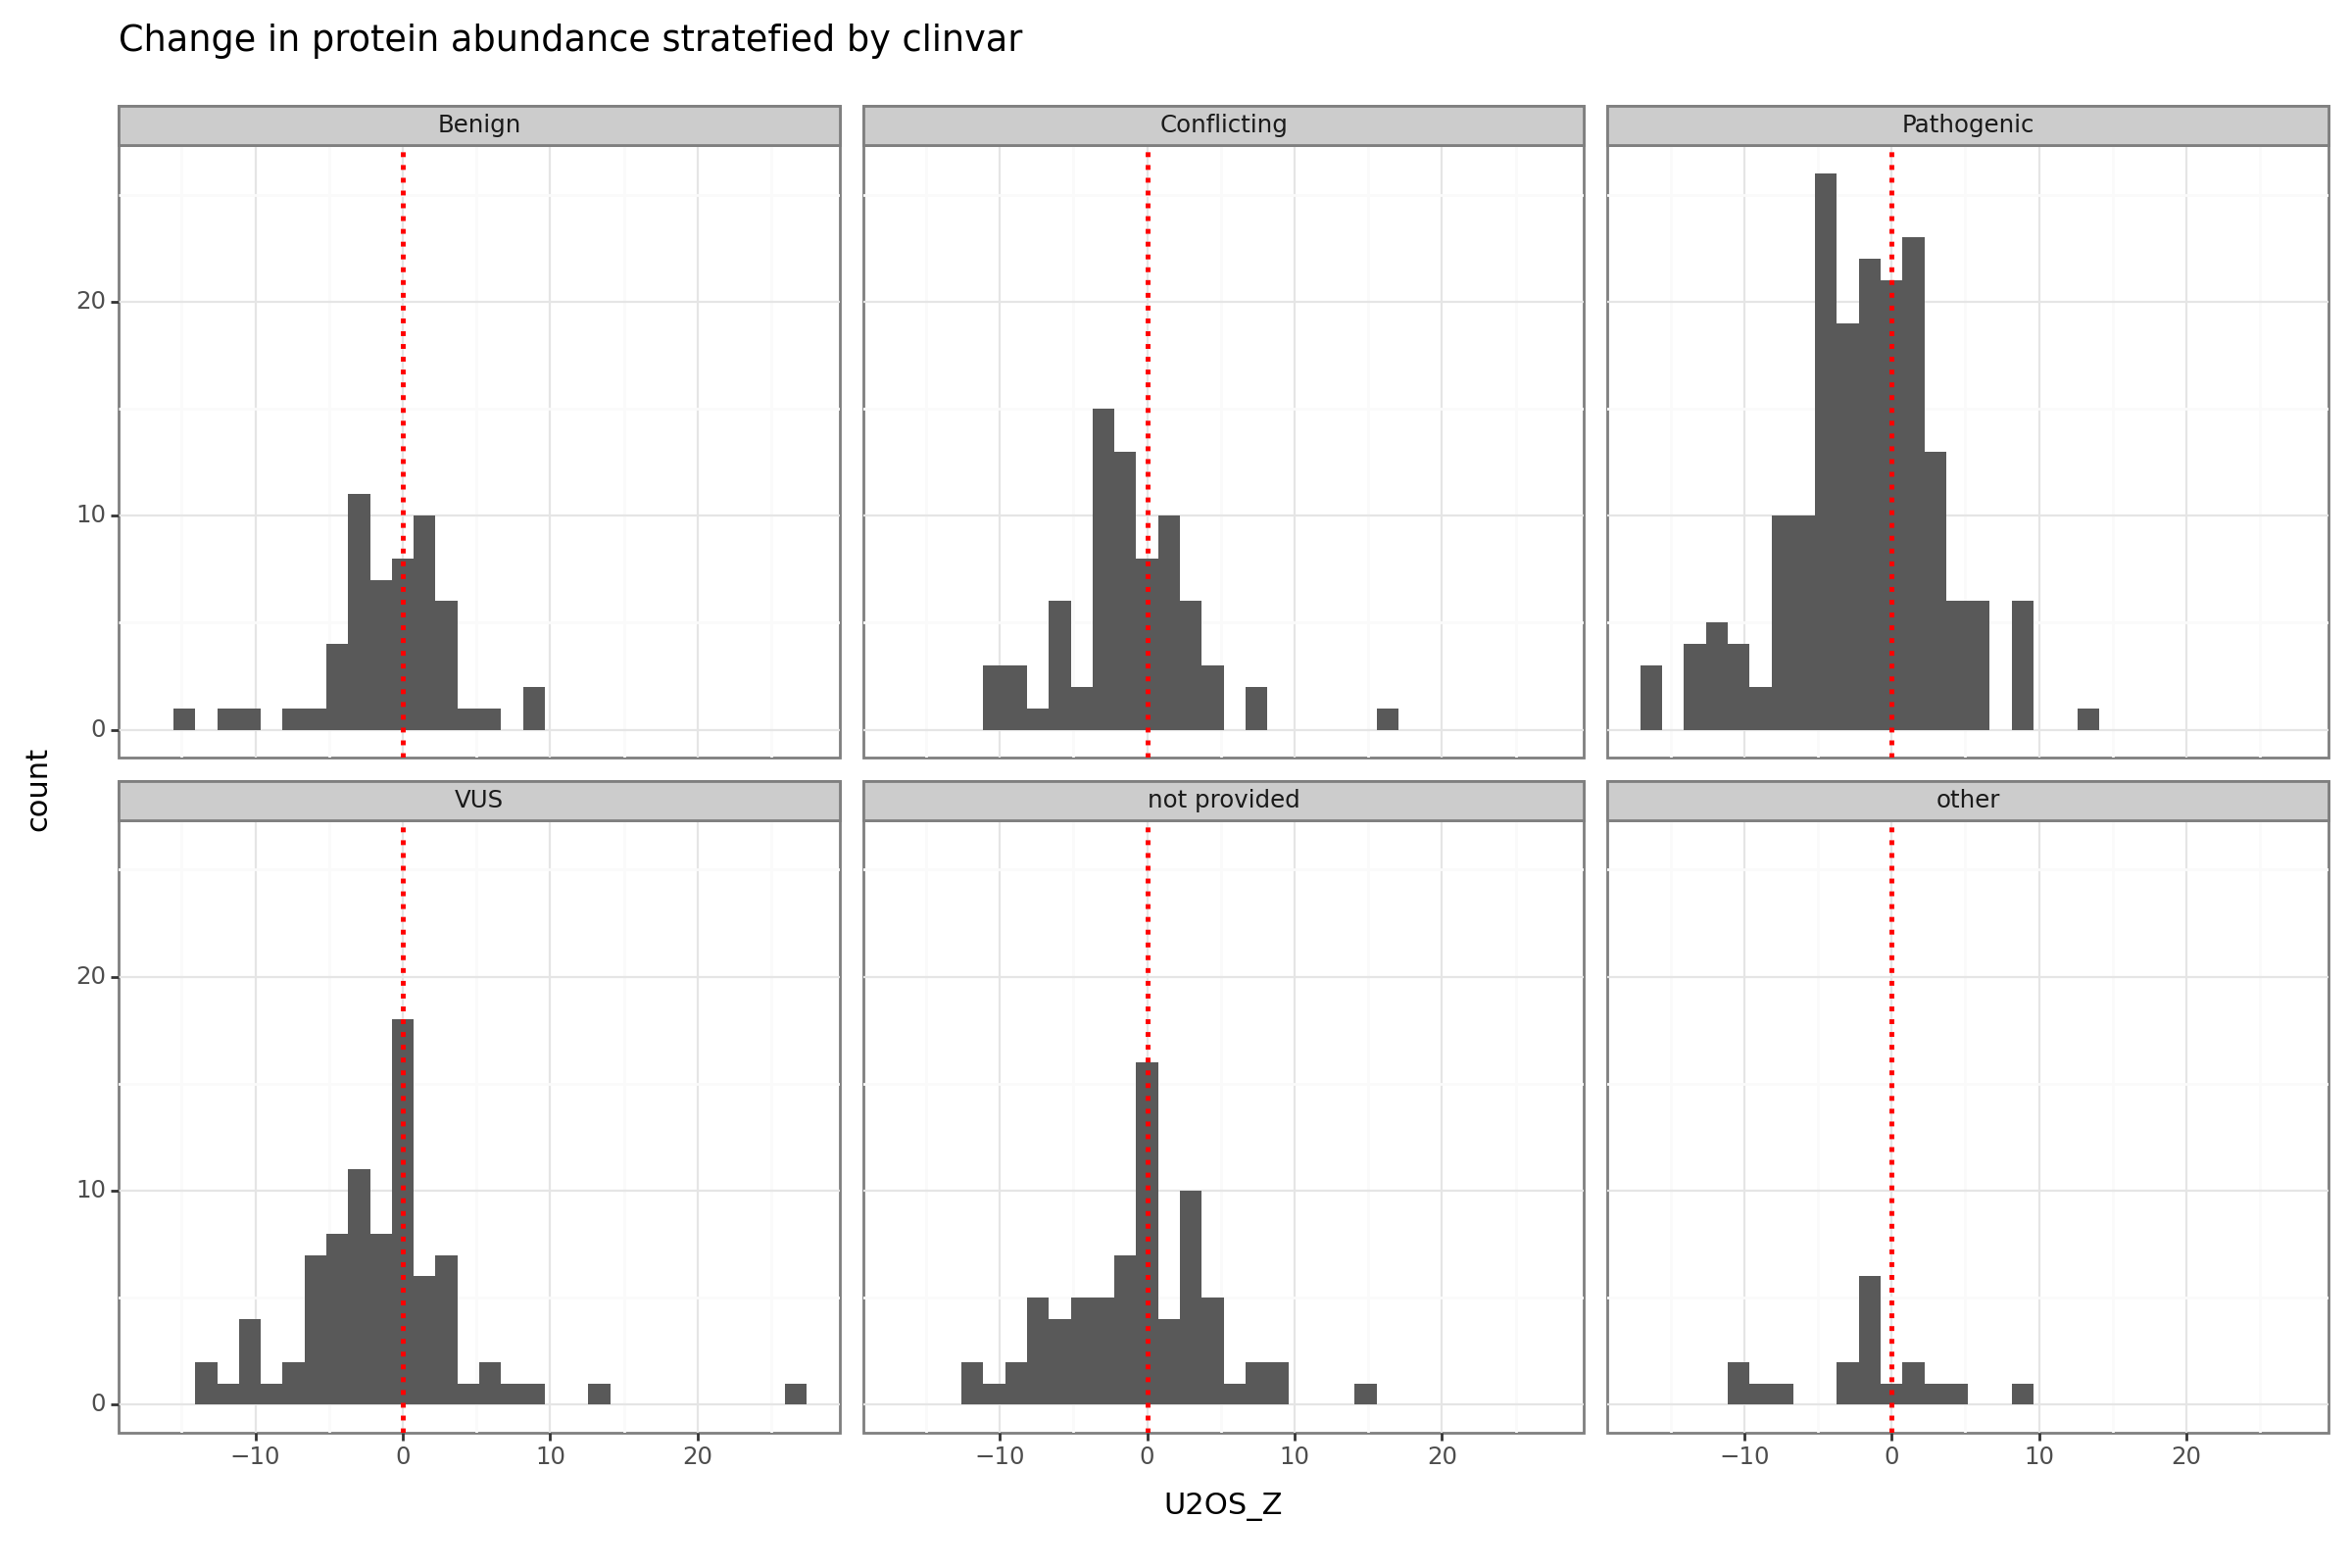

In [11]:
from plotnine import aes, geom_histogram, ggplot, theme_bw, labs, facet_wrap, geom_vline

plotnine.options.figure_size = (12, 8)
plot1 = (
    ggplot(
        well_abun_stats,
        aes(x="U2OS_Z"),
    )
    + geom_histogram()
    + facet_wrap("clinvar_cs")
    + geom_vline(xintercept=0, color="red", linetype="dotted", size=1)
    + theme_bw()
    + labs(title="Change in protein abundance stratefied by clinvar")
)
print(plot1)

## Compare USO2 to DUAL using raw values

Discussion of columns in this dataset:

- avg_gfp: average GFP signal (actual protein abundance level)
- avg_mcherry: average mCherry signal (overexpression level)
- avg_GFP_mCherry_ratio: abundance:expression - this should give a measure of stability
- valid_well: did the well pass various QA/QC thresholds?
    - 800 cells with mCherry > 500 (similar to imaging selection agent + cell count filter)
    - avg reference GFP > 100
- valid_gfp_mcherry_ratio: I don't know how this is different from 'valid_well'

Analysis questions
- what is the correlation between U2OS GFP intensity versus avg_GFP?
    - Do not compare z-stats ... would have to re-compute z-stats using only avg_GFP and not avg_GFP_mCherry_ratio
    - Try for all, valid_well, and valid_gfp_mcherry_ratio
    - Compute median value across all batches (imaging) and mut_id (DUAL)

In [12]:
# Get SC intensity values
b7_alleles = (
    pl.scan_parquet(
        f"{prof_dir}/2024_01_23_Batch_7/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells_metacorr.parquet"
    )
    .select([
        "Metadata_CellID",
        "Metadata_gene_allele",
        "Metadata_Well",
        "Metadata_Plate",
    ])
)
b8_alleles = (
    pl.scan_parquet(
        f"{prof_dir}/2024_02_06_Batch_8/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells_metacorr.parquet"
    )
    .select([
        "Metadata_CellID",
        "Metadata_gene_allele",
        "Metadata_Well",
        "Metadata_Plate",
    ])
)

cell_alleles = pl.concat([b7_alleles.collect(), b8_alleles.collect()])

b7_prof = pl.scan_parquet(
    f"{prof_dir}/2024_01_23_Batch_7/profiles.parquet"
).with_columns(
    pl.concat_str(
        [
            "Metadata_Plate",
            "Metadata_Well",
            "Metadata_ImageNumber",
            "Metadata_ObjectNumber",
        ],
        separator="_",
    ).alias("Metadata_CellID")
)
b8_prof = pl.scan_parquet(
    f"{prof_dir}/2024_02_06_Batch_8/profiles.parquet"
).with_columns(
    pl.concat_str(
        [
            "Metadata_Plate",
            "Metadata_Well",
            "Metadata_ImageNumber",
            "Metadata_ObjectNumber",
        ],
        separator="_",
    ).alias("Metadata_CellID")
)

In [13]:
# Take median
gfp_int = pl.concat([
    b7_prof.select(["Metadata_CellID", "Cells_Intensity_MedianIntensity_GFP"]).collect(),
    b8_prof.select(["Metadata_CellID", "Cells_Intensity_MedianIntensity_GFP"]).collect(),
])

gfp_int = cell_alleles.join(gfp_int, on="Metadata_CellID", how="left")

gfp_int = gfp_int.group_by("Metadata_gene_allele").agg(
    pl.mean("Cells_Intensity_MedianIntensity_GFP").alias("Mean_GFP_Intensity")
)

In [14]:
# Combine with dual stats
dual_stats = pl.read_csv("../results/pDEST_DUAL_avg.tsv", separator="\t")
dual_stats = dual_stats.with_columns(
    pl.when(pl.col("aa_change") == "WT").then("symbol").otherwise(
        pl.concat_str(["symbol", "aa_change"], separator="_")
    ).alias("Metadata_gene_allele")
)

dual_stats_nofilt = dual_stats.group_by("Metadata_gene_allele").agg(
    pl.mean("avg_gfp").alias("avg_gfp"),
    pl.mean("avg_GFP_mCherry_ratio").alias("avg_GFP_mCherry_ratio")
)

dual_stats_wellfilt = dual_stats.filter(pl.col("valid_well") == True).group_by("Metadata_gene_allele").agg(
    pl.mean("avg_gfp").alias("avg_gfp"),
    pl.mean("avg_GFP_mCherry_ratio").alias("avg_GFP_mCherry_ratio")
)

dual_stats_ratiofilt = dual_stats.filter(pl.col("valid_gfp_mcherry_ratio") == True).group_by("Metadata_gene_allele").agg(
    pl.mean("avg_gfp").alias("avg_gfp"),
    pl.mean("avg_GFP_mCherry_ratio").alias("avg_GFP_mCherry_ratio")
)

In [15]:
gfp_int_nofilt = gfp_int.join(dual_stats_nofilt, on="Metadata_gene_allele")
gfp_int_wellfilt = gfp_int.join(dual_stats_wellfilt, on="Metadata_gene_allele")
gfp_int_ratiofilt = gfp_int.join(dual_stats_ratiofilt, on="Metadata_gene_allele")

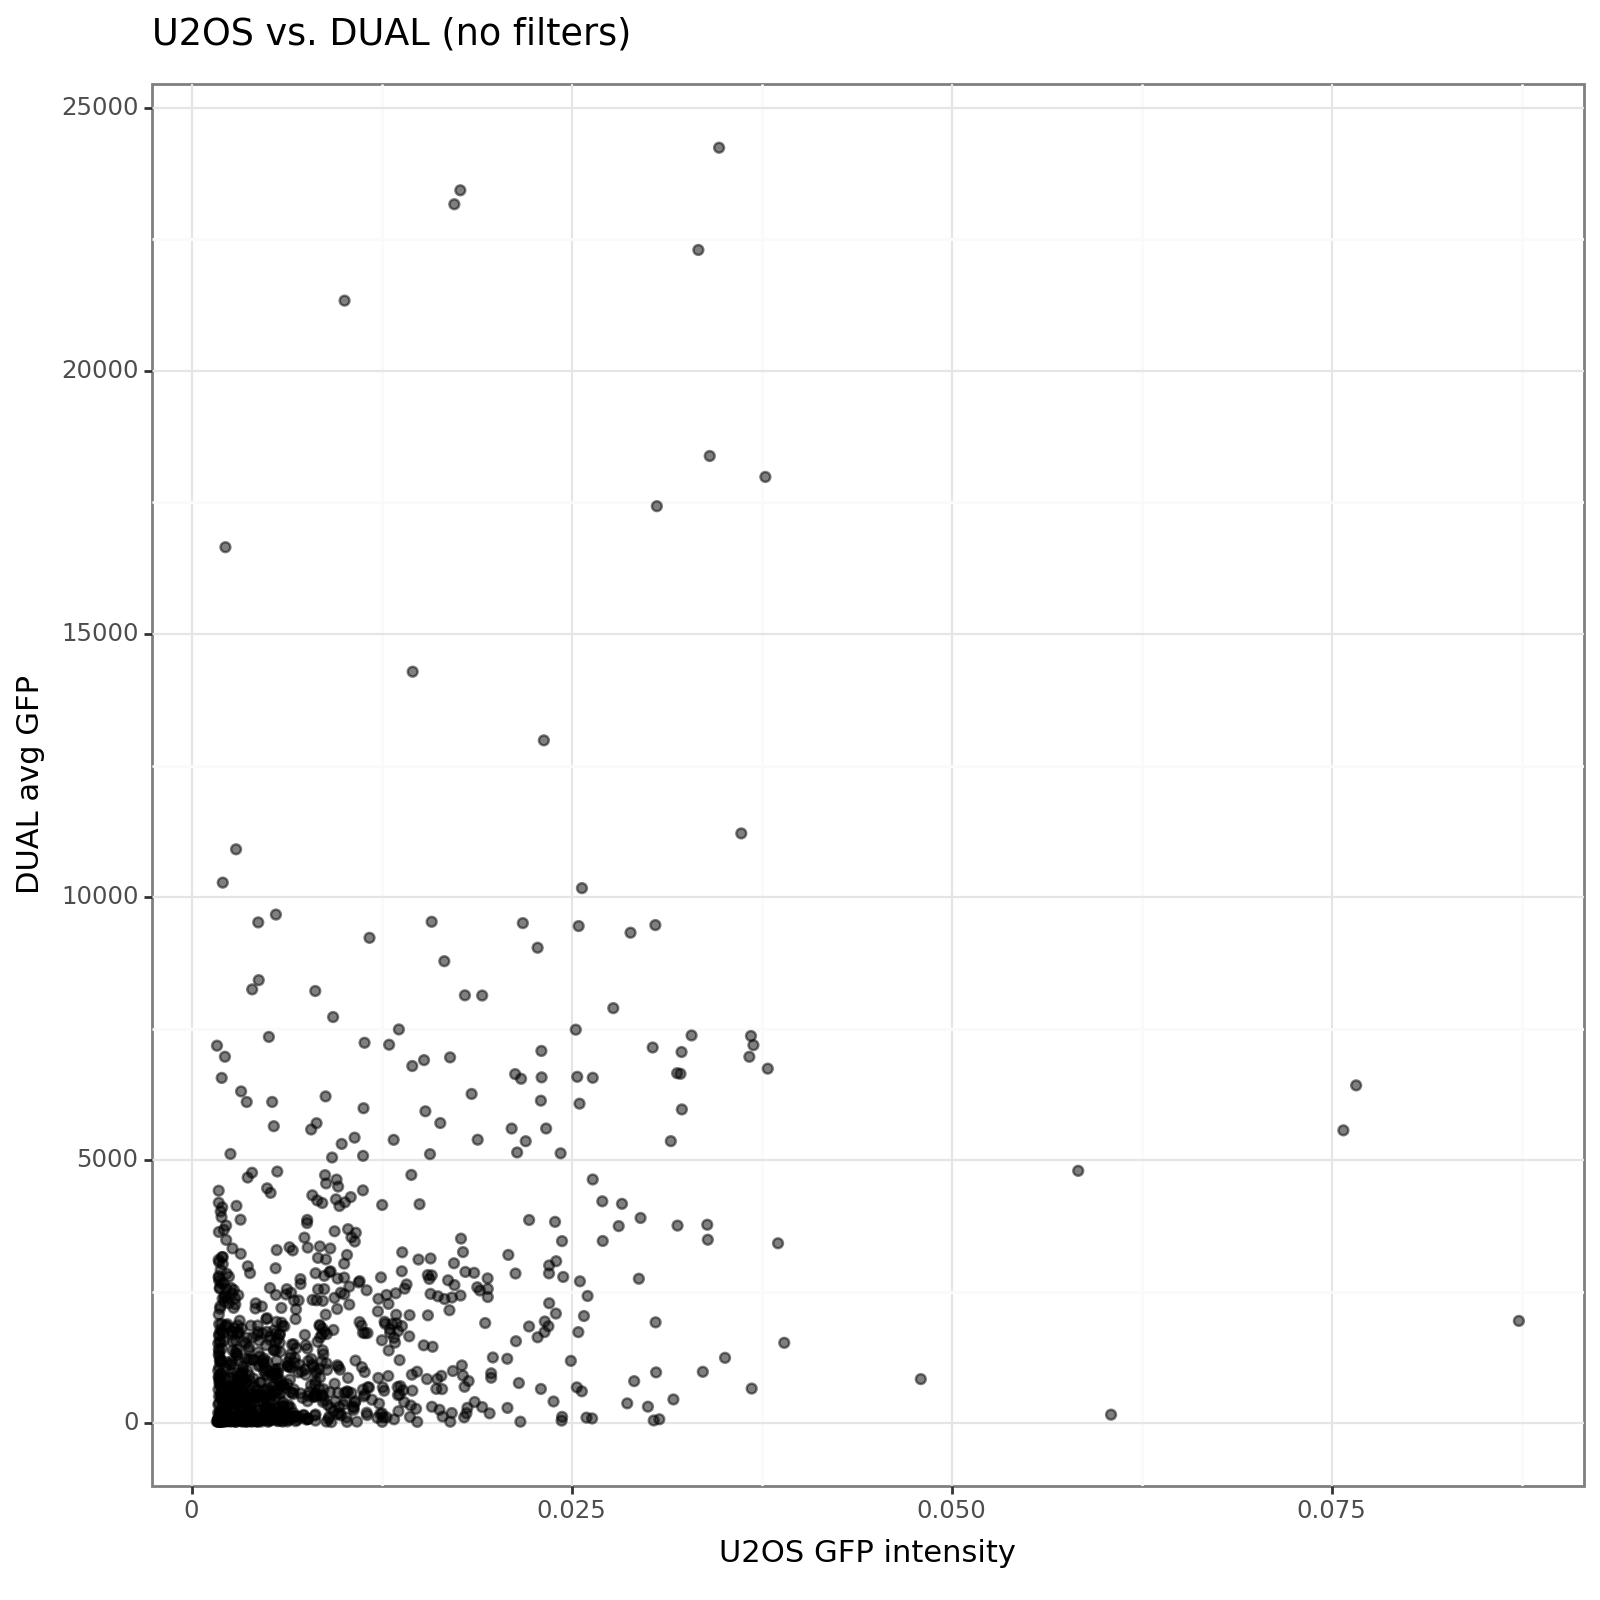

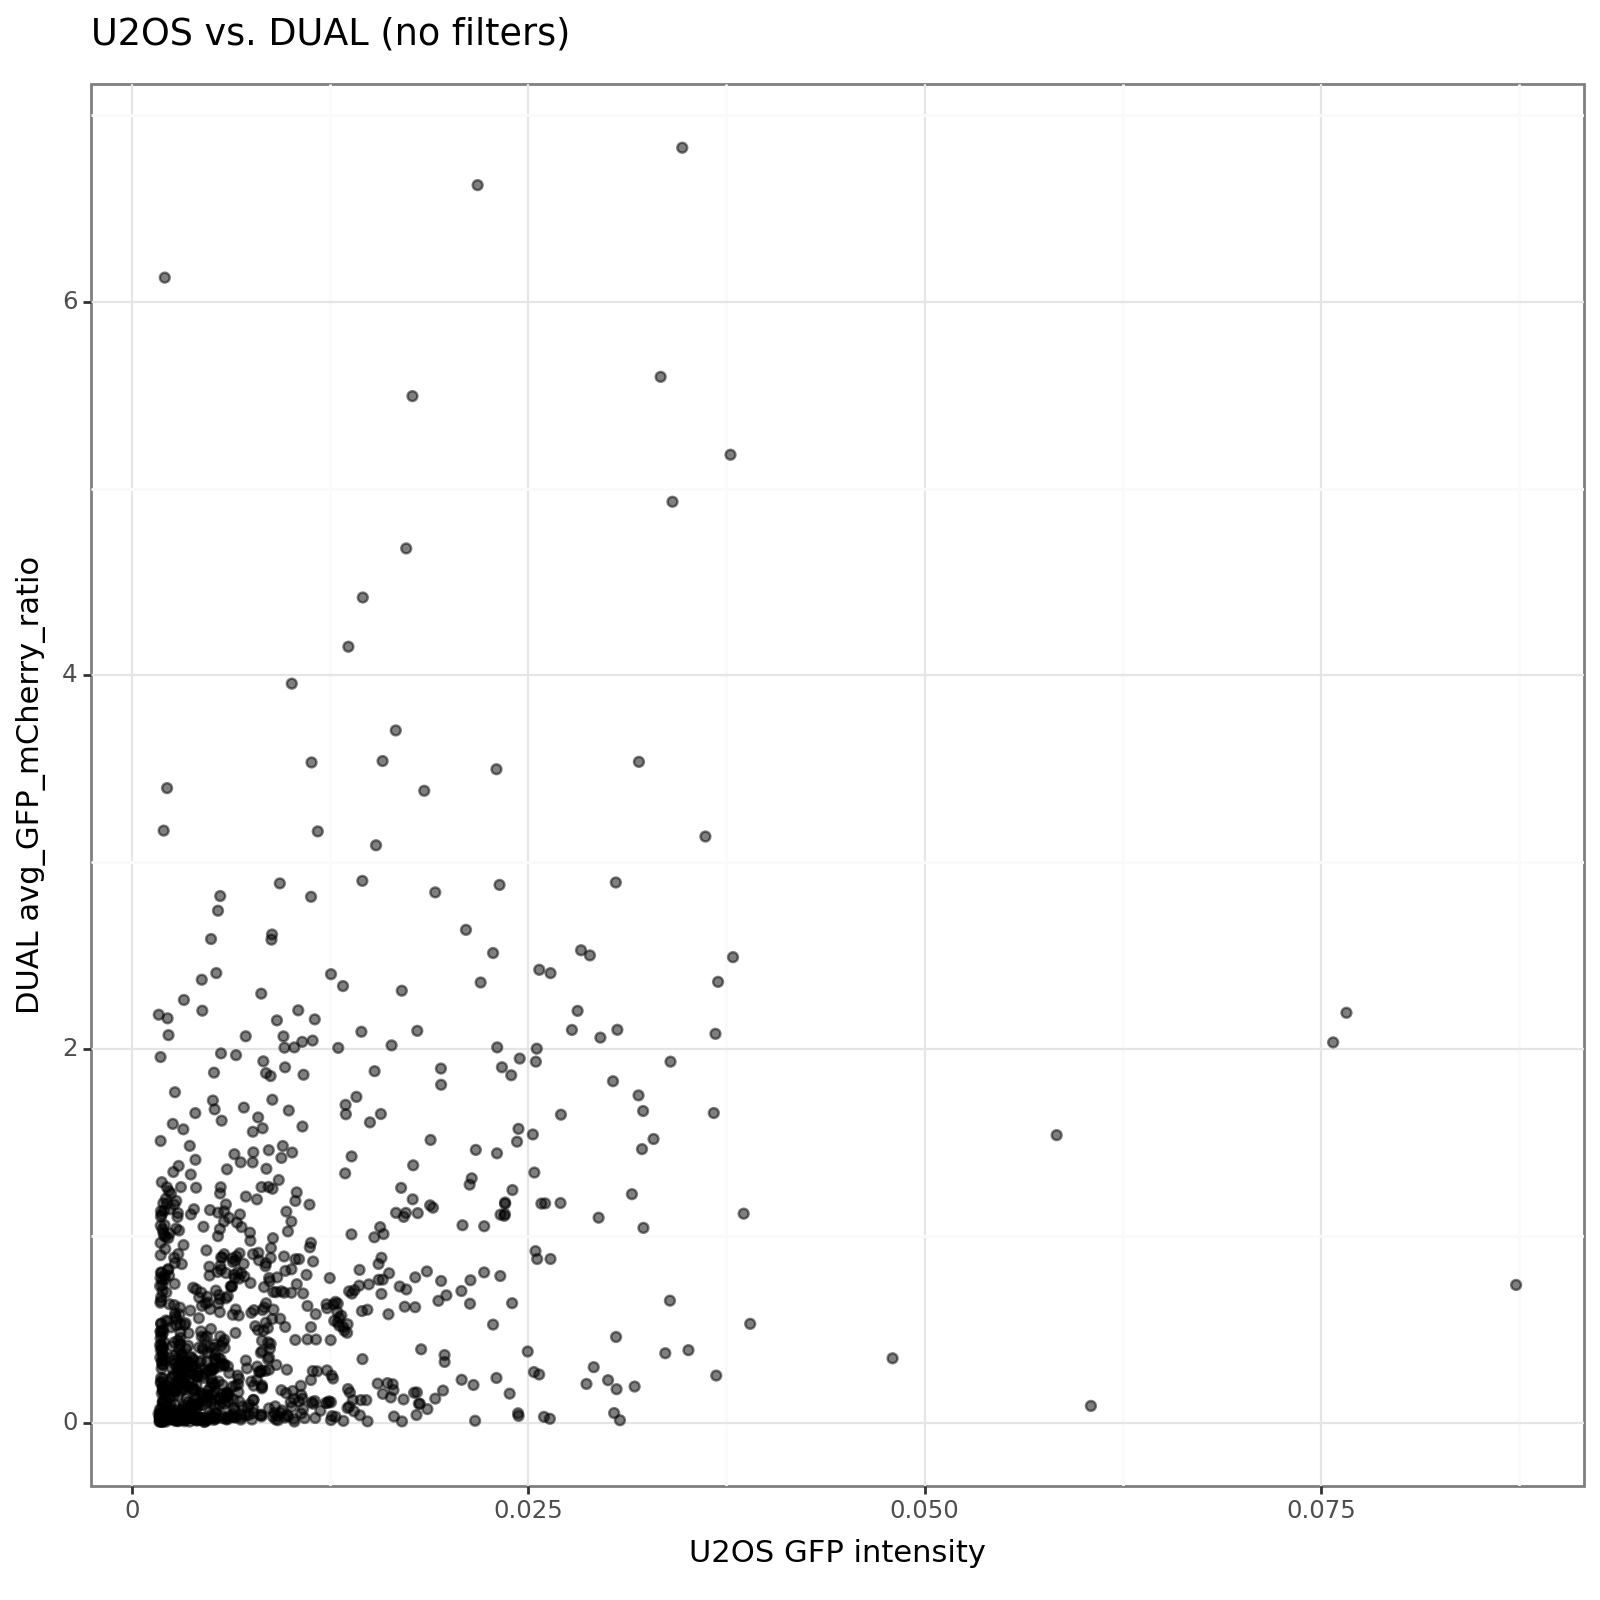

In [16]:
from plotnine import aes, geom_point, ggplot, theme_bw, labs
plotnine.options.figure_size = (8, 8)

plot1 = (
    ggplot(
        gfp_int_nofilt,
        aes(x="Mean_GFP_Intensity", y="avg_gfp"),
    )
    + geom_point(alpha=0.5)
    + theme_bw()
    + labs(title="U2OS vs. DUAL (no filters)", x="U2OS GFP intensity", y="DUAL avg GFP")
)
print(plot1)

plot1 = (
    ggplot(
        gfp_int_nofilt,
        aes(x="Mean_GFP_Intensity", y="avg_GFP_mCherry_ratio"),
    )
    + geom_point(alpha=0.5)
    + theme_bw()
    + labs(title="U2OS vs. DUAL (no filters)", x="U2OS GFP intensity", y="DUAL avg_GFP_mCherry_ratio")
)
print(plot1)

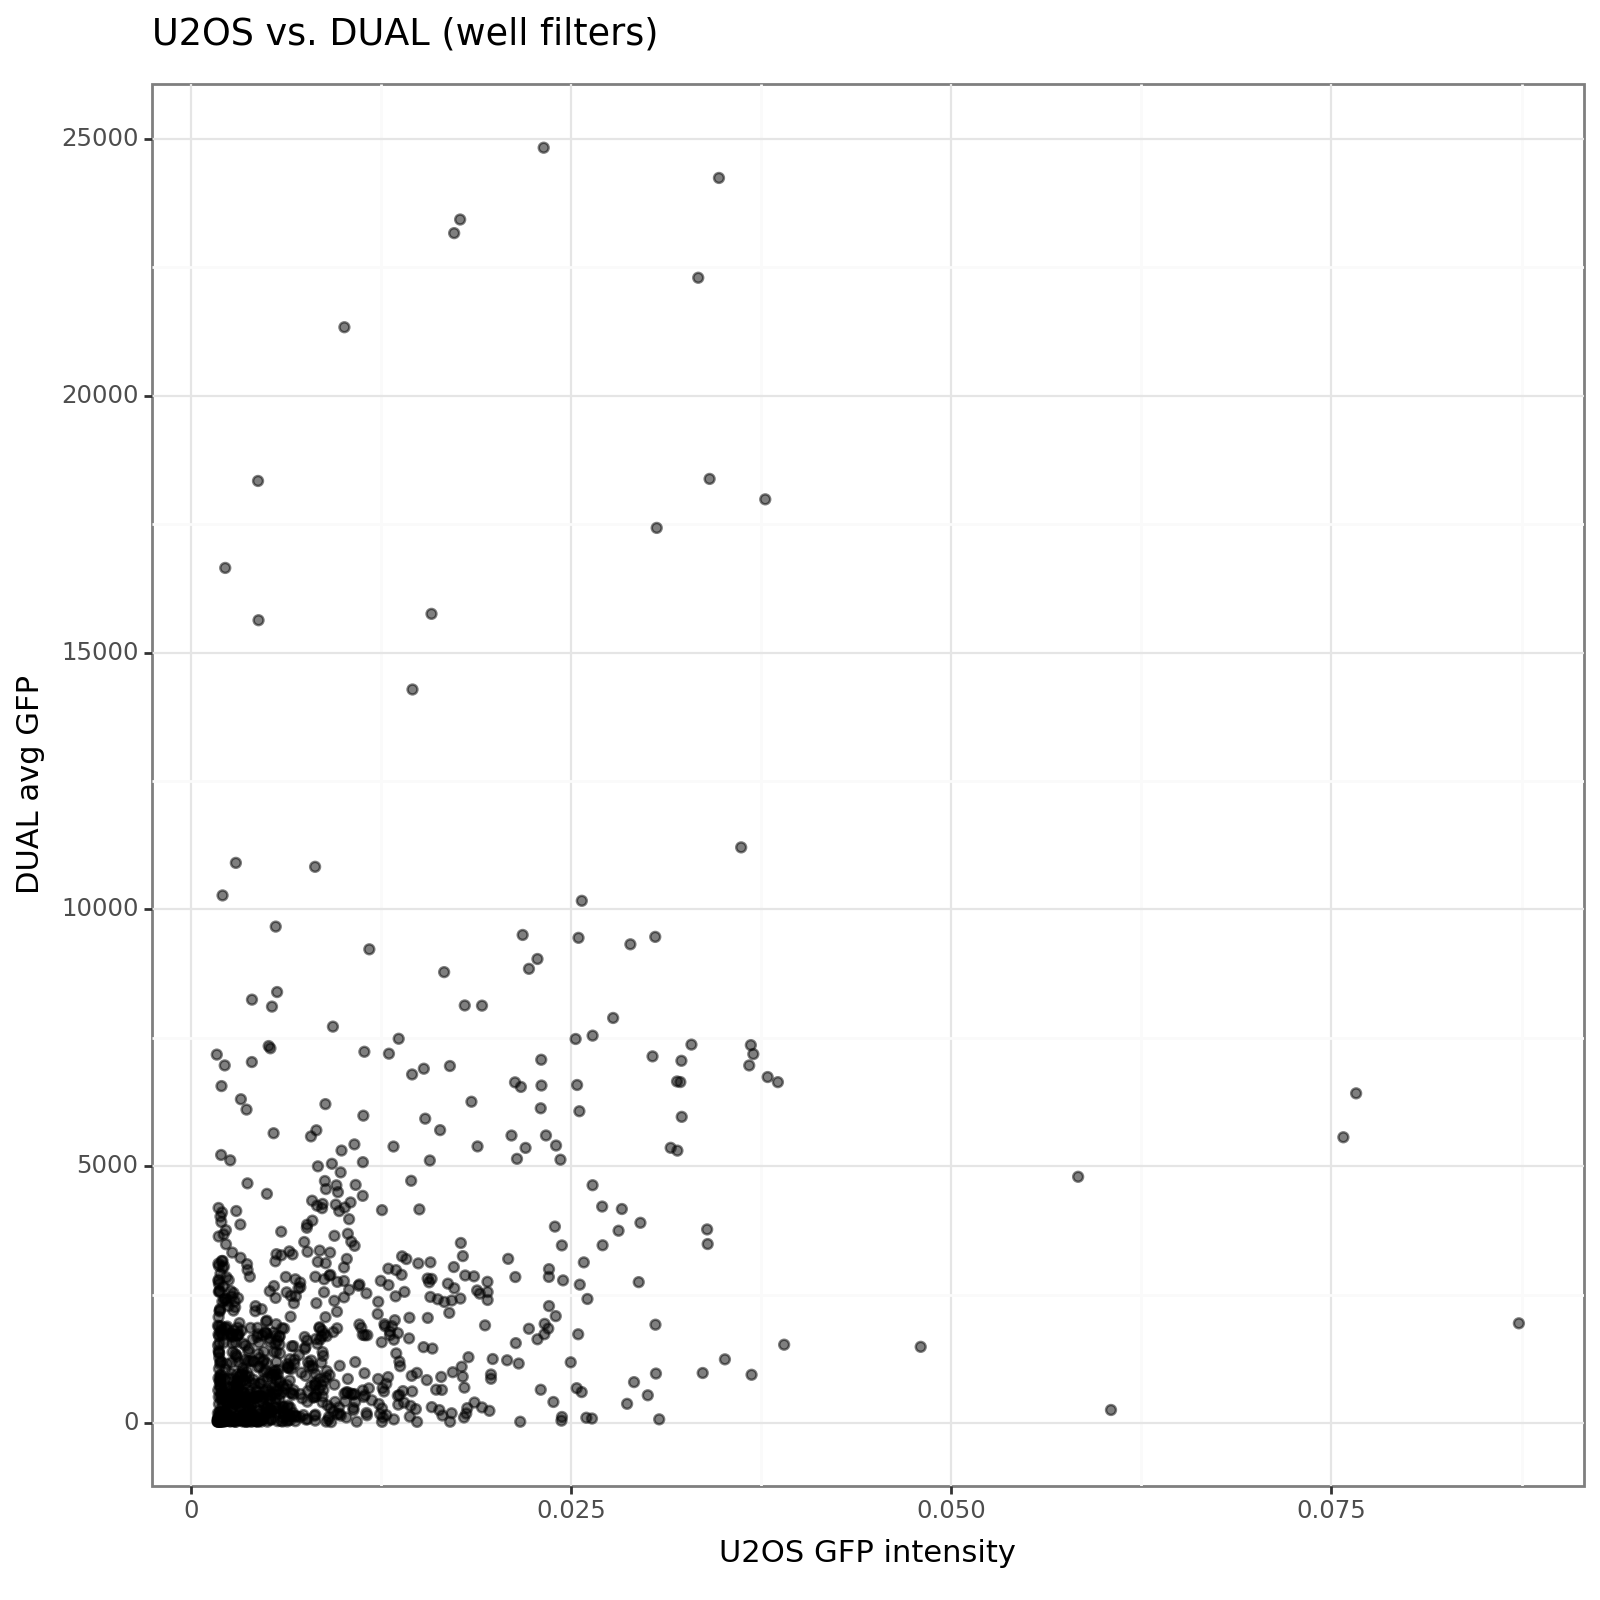

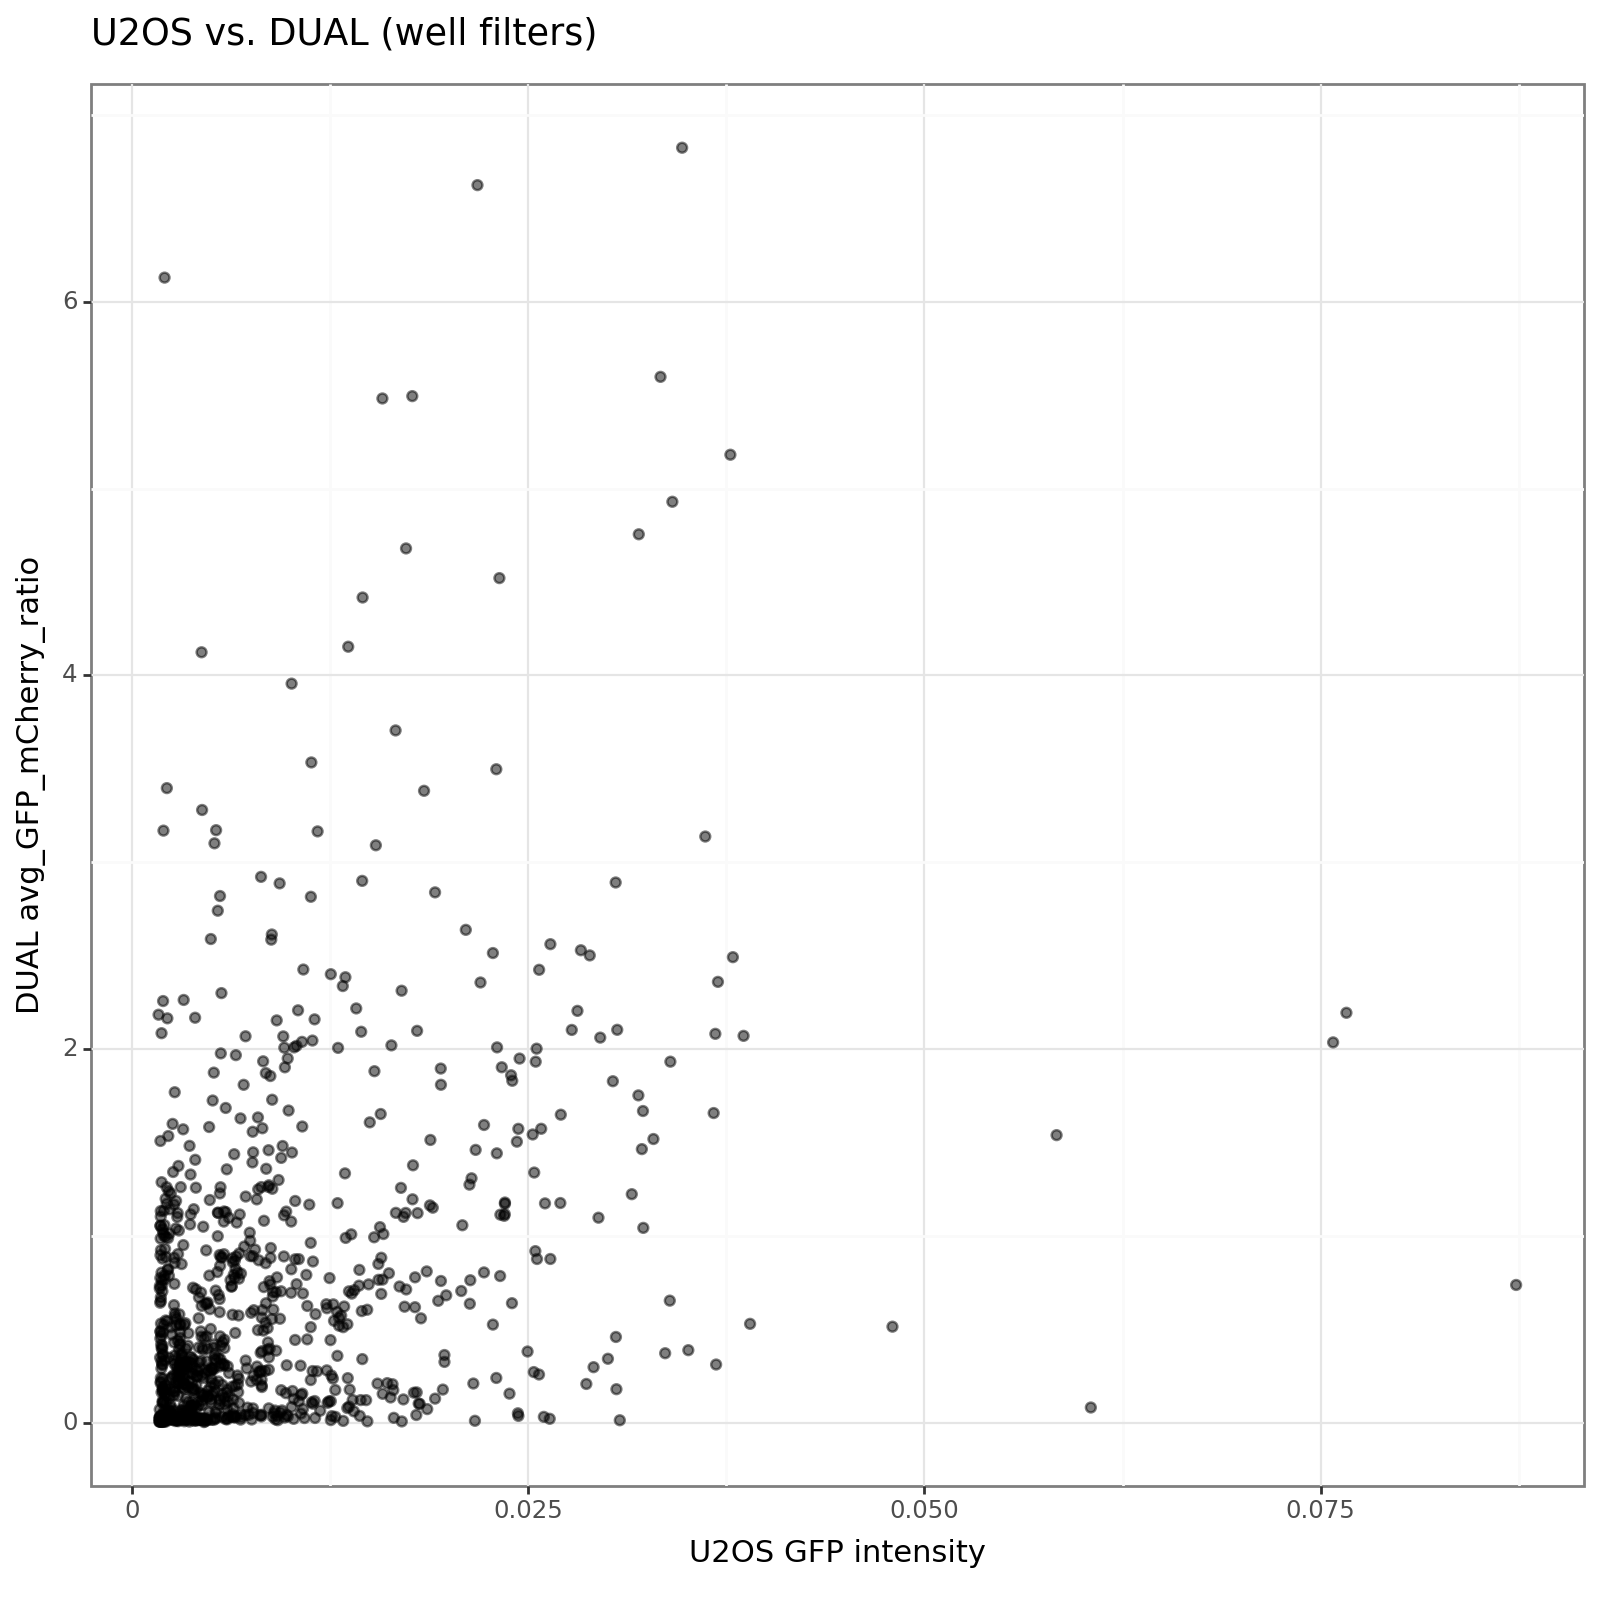

In [17]:
from plotnine import aes, geom_point, ggplot, theme_bw, labs
plotnine.options.figure_size = (8, 8)

plot1 = (
    ggplot(
        gfp_int_wellfilt,
        aes(x="Mean_GFP_Intensity", y="avg_gfp"),
    )
    + geom_point(alpha=0.5)
    + theme_bw()
    + labs(title="U2OS vs. DUAL (well filters)", x="U2OS GFP intensity", y="DUAL avg GFP")
)
print(plot1)

plot1 = (
    ggplot(
        gfp_int_wellfilt,
        aes(x="Mean_GFP_Intensity", y="avg_GFP_mCherry_ratio"),
    )
    + geom_point(alpha=0.5)
    + theme_bw()
    + labs(title="U2OS vs. DUAL (well filters)", x="U2OS GFP intensity", y="DUAL avg_GFP_mCherry_ratio")
)
print(plot1)

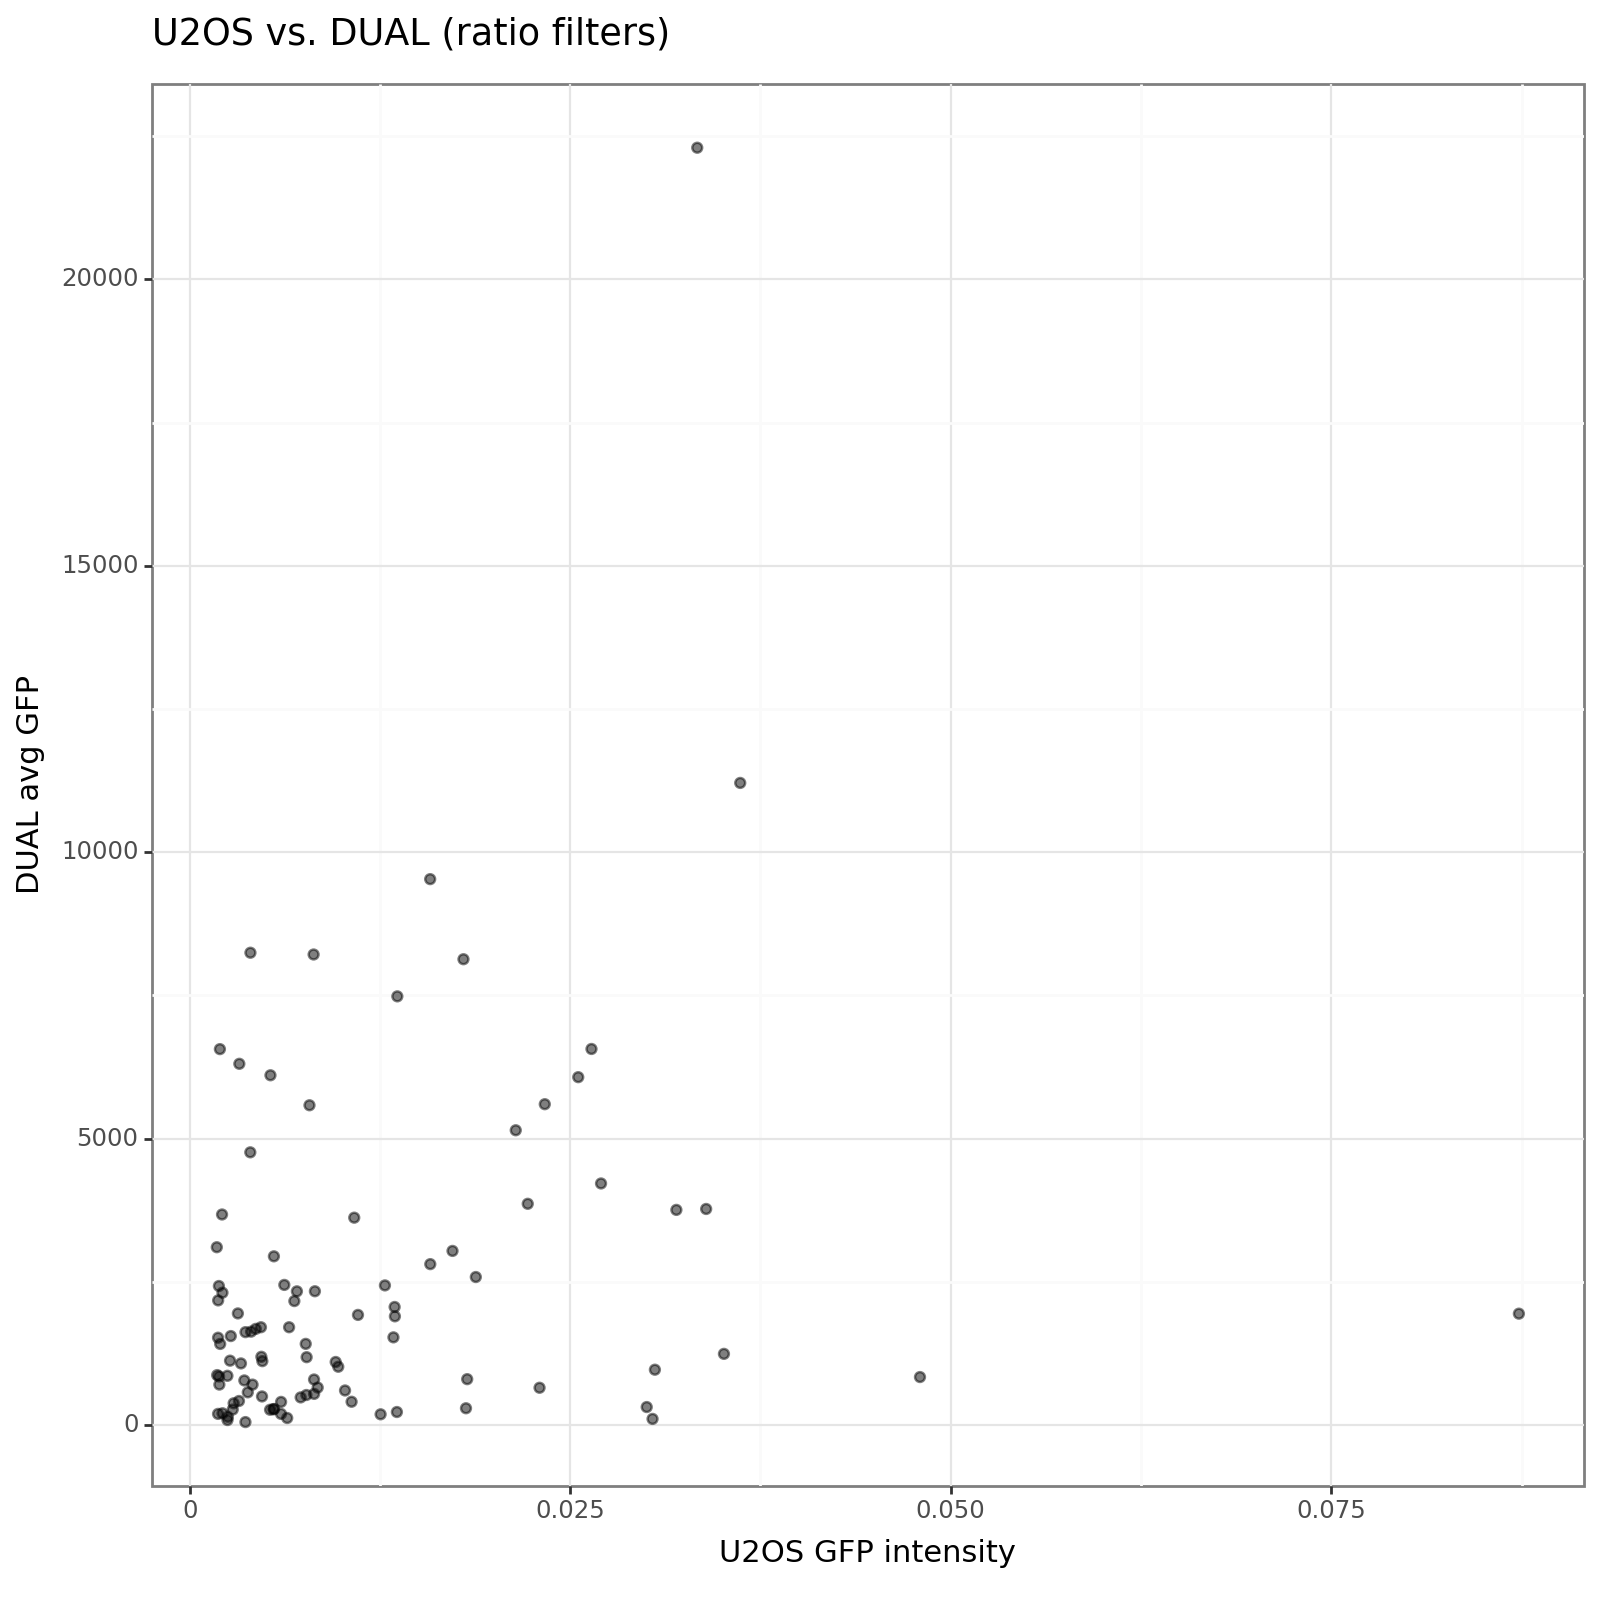

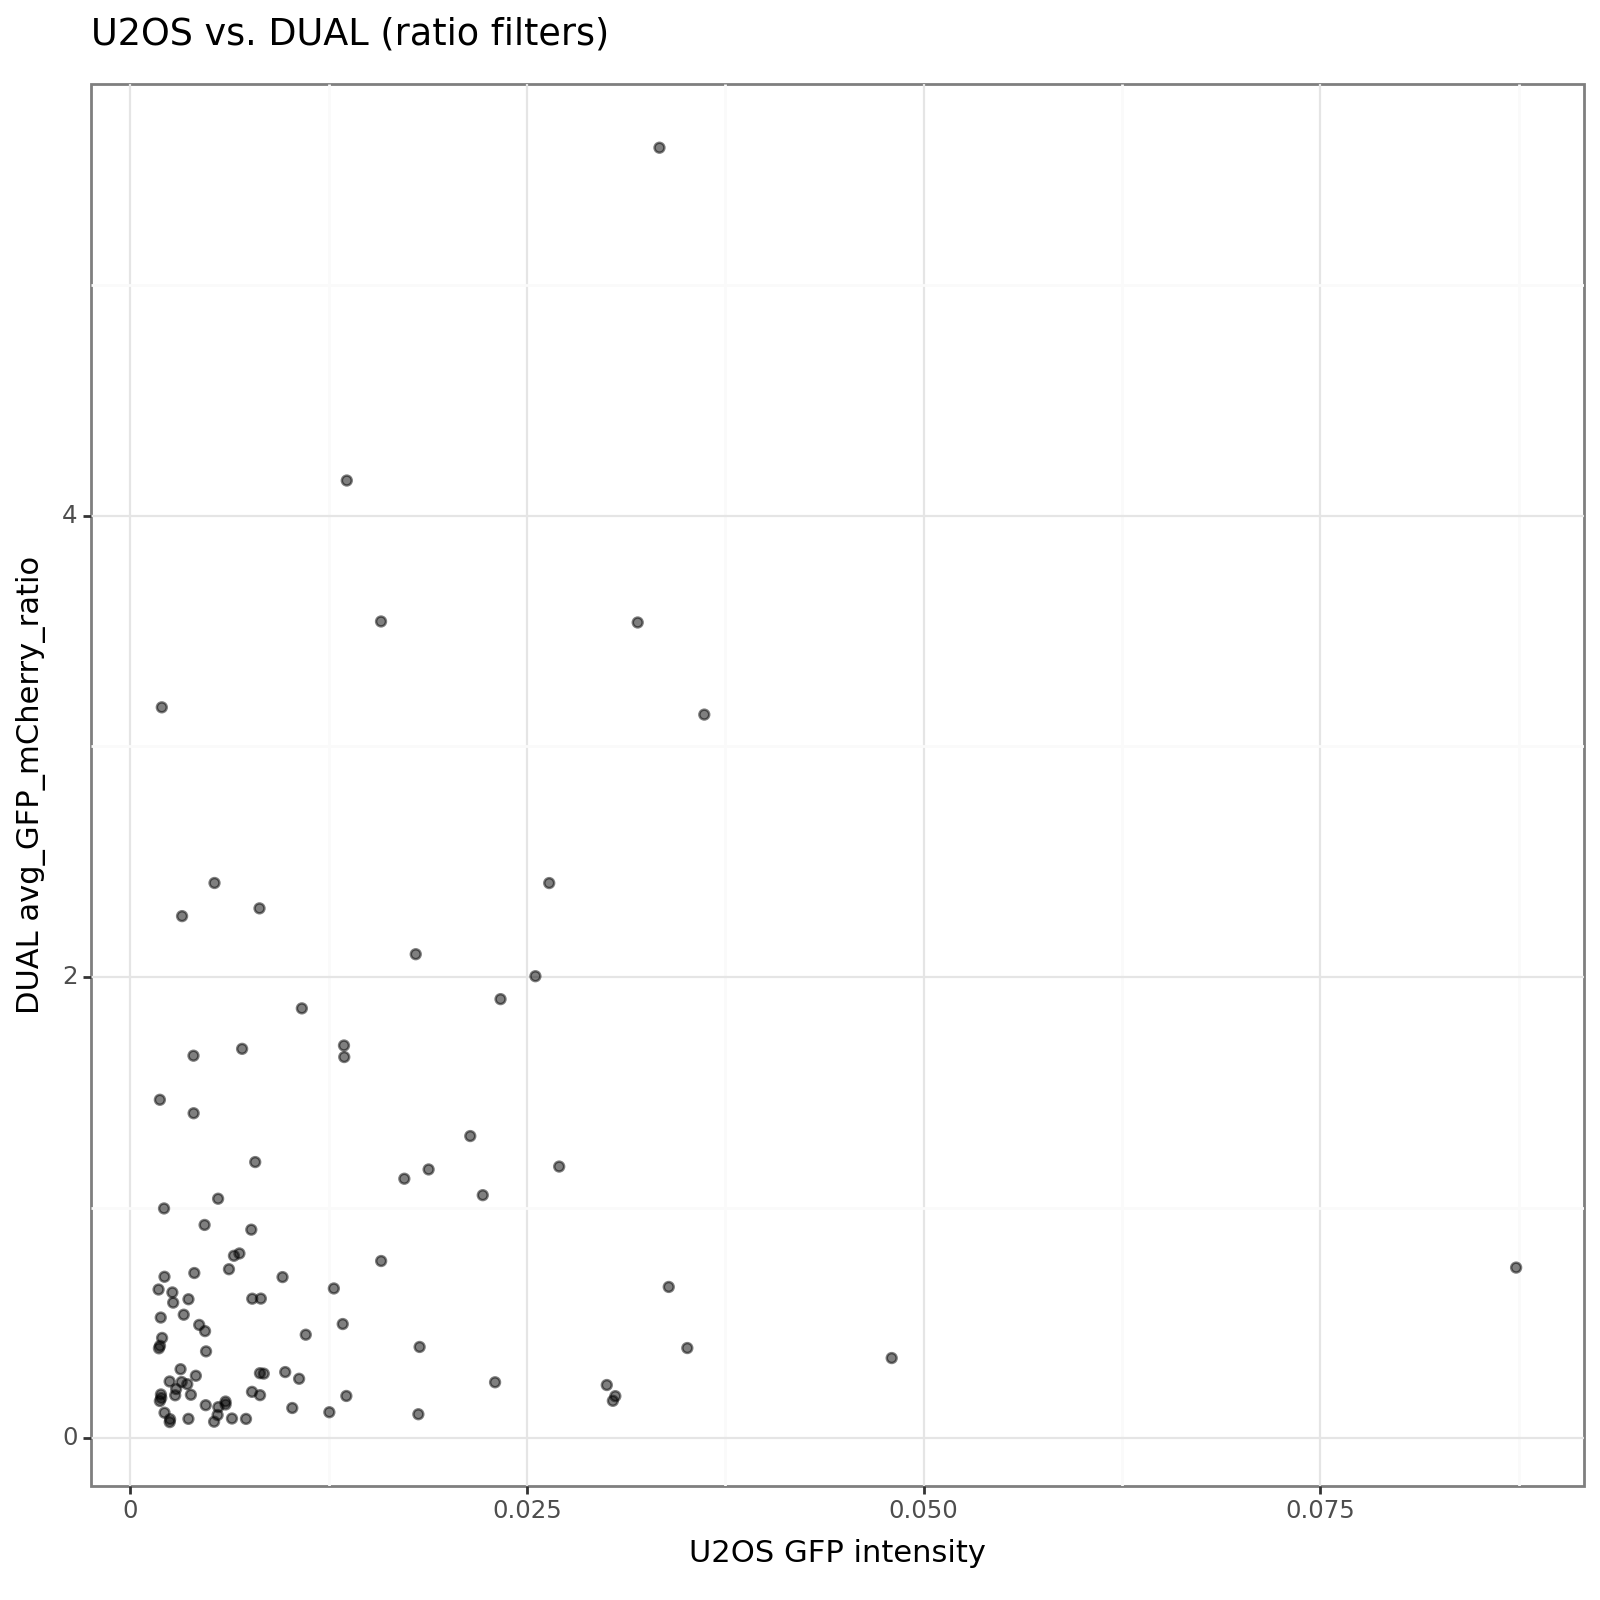

In [18]:
from plotnine import aes, geom_point, ggplot, theme_bw, labs
plotnine.options.figure_size = (8, 8)

plot1 = (
    ggplot(
        gfp_int_ratiofilt,
        aes(x="Mean_GFP_Intensity", y="avg_gfp"),
    )
    + geom_point(alpha=0.5)
    + theme_bw()
    + labs(title="U2OS vs. DUAL (ratio filters)", x="U2OS GFP intensity", y="DUAL avg GFP")
)
print(plot1)

plot1 = (
    ggplot(
        gfp_int_ratiofilt,
        aes(x="Mean_GFP_Intensity", y="avg_GFP_mCherry_ratio"),
    )
    + geom_point(alpha=0.5)
    + theme_bw()
    + labs(title="U2OS vs. DUAL (ratio filters)", x="U2OS GFP intensity", y="DUAL avg_GFP_mCherry_ratio")
)
print(plot1)

Conclusions:
- I see no correlation between raw GFP intensity between assays
- Using GFP:mCherry ratio from DUAL does not help
- Filtering the DUAL data by various criteria does not help

Next steps: get Z-stats computed from just the avg_gfp values, not from the gfp:mCherry ratios.